In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.stats import ttest_ind, ranksums
from decimal import Decimal
import math
import warnings
import statsmodels.api as sm
import os
import glob


# Format
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 700)
sns.set(font_scale=1.1)
# sns.set(rc={"axes.style": "darkgrid"})

# Warnings
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore", category=RuntimeWarning)


from matplotlib.cbook import boxplot_stats  # Para obtener los outliers en un boxplot

# boxplot_stats(df_blocks_filtered['antisaccade_errors']).pop(0)['fliers']


In [2]:
def pre_processing(
    df: pd.DataFrame,
    type_of_saccade: str,
    NEW_SAMPLING_RATE=30,
    baseline_start=-200.0,
    baseline_end=100.0,
    interpolate=False,
    cue_shown_at_left=None,
    threshold_to_accept_sacc=0.5,
    FILTER=1.5,
    filter_by_block=False,
    selected_block=1,
    savgol_flag=False
) -> dict:
    """Pre process webcam eye tracking data

    Args:
        df (pd.DataFrame): _description_
        type_of_saccade (str): _description_
        NEW_SAMPLING_RATE (int, optional): _description_. Defaults to 30.
        interpolate (bool, optional): _description_. Defaults to False.
        cue_shown_at_left (_type_, optional): _description_. Defaults to None.
        threshold_to_accept_sacc (float, optional): _description_. Defaults to 0.5.

    Returns:
        dict: _description_
    """

    # 0. Estoy sacando los trials de practica (`isTutorial`) y quedandome con las filas que tengan datos de webgazer
    df_saccade = df.query("not webgazer_data.isnull() and isTutorial == False")

    # Le agrego numero de bloque al df
    blocks = sum([[i] * 20 for i in range(1, 17)], [])
    df_saccade.loc[:, "block"] = blocks

    # Filtro por tipo de sacada
    df_saccade = df_saccade.query("typeOfSaccade == @type_of_saccade")

    # filtro por bloque
    if filter_by_block == True:
        df_saccade = df_saccade.query("block == @selected_block")

    webgazer_data = df_saccade["webgazer_data"].map(eval)

    pro_sacc_errors = 0
    anti_sacc_errors = 0

    ts_xs_ys = []
    pro_sacc_errors_rt = []
    pro_sacc_correct_rt = []
    anti_sacc_errors_rt = []
    anti_sacc_correct_rt = []

    for trial in range(len(webgazer_data)):
        t0 = df_saccade["intraEnd"].iloc[trial]
        tf = df_saccade["fixEnd"].iloc[trial]  # Deberia ser t0 - 200
        xs = np.array([i["x"] for i in webgazer_data.iloc[trial]])
        ys = np.array([i["y"] for i in webgazer_data.iloc[trial]])
        ts = np.array([i["t"] - t0 for i in webgazer_data.iloc[trial]])

        # Interpolate
        if interpolate:
            fx = interp1d(ts, xs, kind="linear")
            fy = interp1d(ts, ys, kind="linear")
            samples = int((ts[-1] - (-200)) / 30) #  900 ms / 30 Hz te daria 30 samples
            ts_new = np.linspace(-200, ts[-1], samples)
            xs = fx(ts_new)
            ys = fy(ts_new)
            ts = ts_new

        # 1. Calcular la mediana entre [baseline_start baseline_end] = Xbase
        x_base = np.median(
            xs[(ts > baseline_start) & (ts < baseline_end)]
        )  # [-200, 100]

        y_base = np.median(
            ys[(ts > baseline_start) & (ts < baseline_end)]
        )  # [-200, 100]

        # 2. Calcular la mediana entre [500 700] (se puede antibar) = Xmax (o Xmin segun el signo)
        x_max = np.median(xs[(ts > 500.0) & (ts <= 700.0)])
        y_max = np.median(ys[(ts > 500.0) & (ts <= 700.0)])

        # 3. y despues transformas tal que antes de 0 sea 0 y al final sea 1 o -1
        # eso seria: (xs - Xbase) / abs(Xbase - Xmax)
        xs = (xs - x_base) / np.abs(x_base - x_max)
        ys = (ys - y_base) / np.abs(y_base - y_max)

        # 4. Luego de normalizar las estimaciones se espejó la mitad de ellas tal que pudiera asu-
        # mirse que el estímulo visual lateral aparecía siempre del mismo lado. El espejado se realizó
        # multiplicando por −1 las estimaciones de los ensayos en los cuales el estímulo lateral
        # apareciera a izquierda. -> Por lo tanto lo que quede para arriba es mirar en la direccion del estimulo y
        #  para abajo en la direccion opuesta
        if df_saccade["cueShownAtLeft"].iloc[trial] == True:
            xs = xs * -1

        # 5. filtro pasa banda de trials
        if any(xs > FILTER) or any(xs < -FILTER):
            continue

        # # 6. Savitzky-Golay filter
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
        if savgol_flag:
            xs = savgol_filter(xs, 5, 2)

        # 7. Detectar lado en que mira
        xs_after_baseline = xs[ts > baseline_end]
        ts_after_baseline = ts[ts > baseline_end]
        if type_of_saccade == "prosaccade":
            is_sacc_error_in_trial = np.any(
                xs_after_baseline < -threshold_to_accept_sacc
            )
            if is_sacc_error_in_trial:
                pro_sacc_errors += 1
                err_prosacc_idx = np.where(
                    xs_after_baseline < -threshold_to_accept_sacc
                )[0][0]
                err_prosacc_time = ts_after_baseline[err_prosacc_idx]
                pro_sacc_errors_rt.append(f"{err_prosacc_time:.2f}")
            else:
                corr_prosacc_idx = np.where(
                    xs_after_baseline >= threshold_to_accept_sacc
                )[0][0]
                corr_prosacc_time = ts_after_baseline[corr_prosacc_idx]
                pro_sacc_correct_rt.append(f"{corr_prosacc_time:.2f}")

        elif type_of_saccade == "antisaccade":
            is_anti_sacc_error_in_trial = np.any(
                xs_after_baseline > threshold_to_accept_sacc
            )
            if is_anti_sacc_error_in_trial:
                anti_sacc_errors += 1
                err_antisacc_idx = np.where(
                    xs_after_baseline > threshold_to_accept_sacc
                )[0][0]
                err_antisacc_time = ts_after_baseline[err_antisacc_idx]
                anti_sacc_errors_rt.append(f"{err_antisacc_time:.2f}")

            else:
                corr_antisacc_idx = np.where(
                    xs_after_baseline <= -threshold_to_accept_sacc
                )[0][0]
                corr_antisacc_time = ts_after_baseline[corr_antisacc_idx]
                anti_sacc_correct_rt.append(f"{corr_antisacc_time:.2f}")

        ts_xs_ys.append((ts, xs, ys))

    try:
        trials_rejected = 100 - (
            len(ts_xs_ys) / len(webgazer_data) * 100
        )  # len(webgazer_data) = 160 siempre
        pro_saccades_errors_perc = (pro_sacc_errors / len(ts_xs_ys)) * 100
        anti_saccades_errors_perc = (anti_sacc_errors / len(ts_xs_ys)) * 100
    except ZeroDivisionError:
        trials_rejected = 100
        pro_saccades_errors_perc = np.nan
        anti_saccades_errors_perc = np.nan

    return {
        "ts_xs_ys": ts_xs_ys,
        "number_of_trials_remained": len(ts_xs_ys),
        "pro_sacc_errors": pro_sacc_errors,
        "pro_sacc_errors_perc": pro_saccades_errors_perc,
        "anti_sacc_errors": anti_sacc_errors,
        "anti_sacc_errors_perc": anti_saccades_errors_perc,
        "trials_rejected": trials_rejected,
        "pro_sacc_errors_rt": pro_sacc_errors_rt,
        "pro_sacc_correct_rt": pro_sacc_correct_rt,
        "anti_sacc_errors_rt": anti_sacc_errors_rt,
        "anti_sacc_correct_rt": anti_sacc_correct_rt,
        "age": int(eval(df["response"][1])["age"]),
        "px2degree": df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
        "win_width_pixels": df[~df["win_width_deg"].isna()]["win_width_deg"].iloc[0].round(2)
        * df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
        "win_height_pixels": df[~df["win_height_deg"].isna()]["win_height_deg"].iloc[0].round(2)
        * df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
    }



def one_subject(df, suj_number, type_of_saccade):
    fig, axs = plt.subplots(
        3, 1, height_ratios=[1, 4, 1], sharex=True, constrained_layout=True
    )

    suj_number = str(suj_number)
    print("suj_number:", suj_number)
    df = df.query("subject == @suj_number")
    for i in df.query("subject == @suj_number")[type_of_saccade].iloc[0]:
        ts, xs, ys = i[0], i[1], i[2]
        axs[1].plot(ts, xs)

        axs[1].axhline(y=0.5, color="k", linestyle="-")
        axs[1].axhline(y=-0.5, color="k", linestyle="-")
        axs[1].axvline(x=0, color="k", linestyle="-")
        axs[1].set_ylabel("x coordinate predictions")
        # axs[1].set_xlabel("time (ms)")
        axs[1].set_xticks(np.arange(-200, 1000, step=100))
        axs[1].set_xlim(-200, 700)
        axs[1].set_ylim(-2, 2)

    if type_of_saccade == "prosaccade":
        data_error = [float(i) for i in df["pro_sacc_errors_rt"].iloc[0]]
        data_correct = [float(i) for i in df["pro_sacc_correct_rt"].iloc[0]]
        sns.kdeplot(data_error, ax=axs[2])
        sns.rugplot(data_error, ax=axs[2], height=0.1)
        sns.kdeplot(data_correct, ax=axs[0])
        sns.rugplot(data_correct, ax=axs[0], height=0.1)
        axs[2].set_xlim([-200, 700])
        axs[2].invert_yaxis()
        axs[0].set_xlim([-200, 700])

    else:
        data_error = [float(i) for i in df["anti_sacc_errors_rt"].iloc[0]]
        data_correct = [float(i) for i in df["anti_sacc_correct_rt"].iloc[0]]
        sns.kdeplot(data_error, ax=axs[0])
        sns.rugplot(data_error, ax=axs[0], height=0.1)
        sns.kdeplot(data_correct, ax=axs[2])
        sns.rugplot(data_correct, ax=axs[2], height=0.1)
        axs[0].set_xlim([-200, 700])
        axs[2].set_xlim([-200, 700])
        axs[2].invert_yaxis()

    plt.suptitle(f"{type_of_saccade}")
    fig.align_ylabels(axs[:])
    fig.supxlabel("time (ms)")
    plt.show()

def calculate_distance(x_positions):
    distances = np.diff(x_positions)
    distance = np.sum(np.sqrt(distances ** 2))
    return distance

In [24]:
### TESTING SIMPLE

def pre_processing_simple(
    df: pd.DataFrame,
    type_of_saccade: str,
    NEW_SAMPLING_RATE=30,
    baseline_start=-200.0,
    baseline_end=100.0,
    interpolate=False,
    cue_shown_at_left=None,
    threshold_to_accept_sacc=0.5,
    FILTER=1.5,
    filter_by_block=False,
    selected_block=1,
    savgol_flag=False
) -> dict:
    """Pre process webcam eye tracking data

    Args:
        df (pd.DataFrame): _description_
        type_of_saccade (str): _description_
        NEW_SAMPLING_RATE (int, optional): _description_. Defaults to 30.
        interpolate (bool, optional): _description_. Defaults to False.
        cue_shown_at_left (_type_, optional): _description_. Defaults to None.
        threshold_to_accept_sacc (float, optional): _description_. Defaults to 0.5.

    Returns:
        dict: _description_
    """

    # 0. Estoy sacando los trials de practica (`isTutorial`) y quedandome con las filas que tengan datos de webgazer
    df_saccade = df.query("not webgazer_data.isnull() and isTutorial == False")

    # Le agrego numero de bloque al df
    blocks = sum([[i] * 20 for i in range(1, 17)], [])
    df_saccade.loc[:, "block"] = blocks

    # Filtro por tipo de sacada
    df_saccade = df_saccade.query("typeOfSaccade == @type_of_saccade")

    # filtro por bloque
    if filter_by_block == True:
        df_saccade = df_saccade.query("block == @selected_block")

    webgazer_data = df_saccade["webgazer_data"].map(eval)

    pro_sacc_errors = 0
    anti_sacc_errors = 0

    ts_xs = []
    
    all_xs_baseline = []
    all_xs = []
    all_ts_baseline = []
    all_ts = []

    pro_sacc_errors_rt = []
    pro_sacc_correct_rt = []
    anti_sacc_errors_rt = []
    anti_sacc_correct_rt = []


    all_x_base = []
    for state in ['first', 'second']:
        for trial in range(len(webgazer_data)):
            t0 = df_saccade["intraEnd"].iloc[trial]
            tf = df_saccade["fixEnd"].iloc[trial]  # Deberia ser t0 - 200
            xs = np.array([i["x"] for i in webgazer_data.iloc[trial]])
            ts = np.array([i["t"] - t0 for i in webgazer_data.iloc[trial]])

            # Interpolate
            if interpolate:
                f1 = interp1d(ts, xs, kind="linear")
                samples = int((ts[-1] - (-200)) / 30) #  900 ms / 30 Hz te daria 30 samples
                ts_new = np.linspace(-200, ts[-1], samples)
                xs = f1(ts_new)
                ts = ts_new

            # 1. Calcular la mediana entre [baseline_start baseline_end] = Xbase
            x_base = np.median(
                xs[(ts > baseline_start) & (ts < baseline_end)]
            )  # [-200, 100]

            if state == 'first':
                all_x_base.append(x_base)

            if state == 'second':
                std_x_base = np.std(all_x_base)
                mean_plus_std = np.mean(all_x_base) + std_x_base * 2
                mean_minus_std = np.mean(all_x_base) - std_x_base * 2
                distance = calculate_distance(np.array(xs))

                # Filter1: If the value of x_base is outside the range of mean_plus_std or mean_minus_std
                if (x_base >  mean_plus_std) or (x_base <  mean_minus_std) :
                    print("filtro")
                    print("x_base:", x_base)
                    print("mean_plus_std:", mean_plus_std)
                    print("mean_minus_std:", mean_minus_std)
                    continue
                else:
                    print("NO FILTRO")
                    # 4. Luego de normalizar las estimaciones se espejó la mitad de ellas tal que pudiera asu-
                    # mirse que el estímulo visual lateral aparecía siempre del mismo lado. El espejado se realizó
                    # multiplicando por −1 las estimaciones de los ensayos en los cuales el estímulo lateral
                    # apareciera a izquierda. -> Por lo tanto lo que quede para arriba es mirar en la direccion del estimulo y
                    #  para abajo en la direccion opuesta
                    if df_saccade["cueShownAtLeft"].iloc[trial] == True:
                        xs = xs * -1

                    # # 5. filtro pasa banda de trials
                    # if any(xs > FILTER) or any(xs < -FILTER):
                    #     continue164.61468164266267

                    # # 6. Savitzky-Golay filter
                    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
                    # if savgol_flag:
                    #     xs = savgol_filter(xs, 5, 2)

                    # 7. Detectar lado en que mira
                    xs_after_baseline = xs[ts > baseline_end]
                    ts_after_baseline = ts[ts > baseline_end]
            
                    all_xs_baseline.append(xs_after_baseline)
                    all_xs.append(xs)
                    all_ts_baseline.append(ts_after_baseline)
                    all_ts.append(ts)
                    ts_xs.append((ts, xs))

    try:
        trials_rejected = 100 - (
            len(ts_xs) / len(webgazer_data) * 100
        )  # len(webgazer_data) = 160 siempre
        pro_saccades_errors_perc = (pro_sacc_errors / len(ts_xs)) * 100
        anti_saccades_errors_perc = (anti_sacc_errors / len(ts_xs)) * 100
    except ZeroDivisionError:
        trials_rejected = 100
        pro_saccades_errors_perc = np.nan
        anti_saccades_errors_perc = np.nan
    
    return {
        "ts_xs": ts_xs,
        "number_of_trials_remained": len(ts_xs),
        "all_xs_baseline": all_xs_baseline,
        "all_xs": all_xs,
        "all_ts_baseline": all_ts_baseline,
        "all_ts": all_ts,
        # "pro_sacc_errors": pro_sacc_errors,
        # "pro_sacc_errors_perc": pro_saccades_errors_perc,
        # "anti_sacc_errors": anti_sacc_errors,
        # "anti_sacc_errors_perc": anti_saccades_errors_perc,
        # "trials_rejected": trials_rejected,
        # "pro_sacc_errors_rt": pro_sacc_errors_rt,
        # "pro_sacc_correct_rt": pro_sacc_correct_rt,
        # "anti_sacc_errors_rt": anti_sacc_errors_rt,
        # "anti_sacc_correct_rt": anti_sacc_correct_rt,
        "age": int(eval(df["response"][1])["age"]),
        "px2degree": df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
        "win_width_pixels": df[~df["win_width_deg"].isna()]["win_width_deg"].iloc[0].round(2)
        * df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
        "win_height_pixels": df[~df["win_height_deg"].isna()]["win_height_deg"].iloc[0].round(2)
        * df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
        "all_x_base": all_x_base
    }

def one_subject(df, suj_number, type_of_saccade):
    fig, axs = plt.subplots(
        3, 1, height_ratios=[1, 4, 1], sharex=True, constrained_layout=True
    )

    suj_number = str(suj_number)
    print("suj_number:", suj_number)
    df = df.query("subject == @suj_number")
    for i in df.query("subject == @suj_number")[type_of_saccade].iloc[0]:
        ts, xs, ys = i[0], i[1], i[2]
        axs[1].plot(ts, xs)

        axs[1].axhline(y=0.5, color="k", linestyle="-")
        axs[1].axhline(y=-0.5, color="k", linestyle="-")
        axs[1].axvline(x=0, color="k", linestyle="-")
        axs[1].set_ylabel("x coordinates normalized")
        # axs[1].set_xlabel("time (ms)")
        axs[1].set_xticks(np.arange(-200, 1000, step=100))
        axs[1].set_xlim(-200, 700)
        axs[1].set_ylim(-2, 2) 

    if type_of_saccade == "prosaccade":
        data_error = [float(i) for i in df["pro_sacc_errors_rt"].iloc[0]]
        data_correct = [float(i) for i in df["pro_sacc_correct_rt"].iloc[0]]
        sns.kdeplot(data_error, ax=axs[2])
        sns.rugplot(data_error, ax=axs[2], height=0.1)
        sns.kdeplot(data_correct, ax=axs[0])
        sns.rugplot(data_correct, ax=axs[0], height=0.1)
        axs[2].set_xlim([-200, 700])
        axs[0].set_xlim([-200, 700])
        axs[2].invert_yaxis()
        axs[2].set(yticklabels=[])
        axs[0].set(yticklabels=[])
        axs[2].set(ylabel=None)
        axs[0].set(ylabel=None)

    else:
        data_error = [float(i) for i in df["anti_sacc_errors_rt"].iloc[0]]
        data_correct = [float(i) for i in df["anti_sacc_correct_rt"].iloc[0]]
        sns.kdeplot(data_error, ax=axs[0])
        sns.rugplot(data_error, ax=axs[0], height=0.1)
        sns.kdeplot(data_correct, ax=axs[2])
        sns.rugplot(data_correct, ax=axs[2], height=0.1)
        axs[0].set_xlim([-200, 700])
        axs[2].set_xlim([-200, 700])
        axs[2].invert_yaxis()
        axs[2].set(yticklabels=[])
        axs[0].set(yticklabels=[])
        axs[2].set(ylabel=None)
        axs[0].set(ylabel=None)

    # plt.suptitle(f"{type_of_saccade}")
    print(type_of_saccade)
    fig.align_ylabels(axs[:])
    fig.supxlabel("time (ms)")

    plt.show()


### Load all files without block separation (simplified version)

In [5]:
# SIMPLIFIED VERSION
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))


df_processed_signal = pd.DataFrame(
    {
        "subject": None,
        "prosaccade": None,
        "antisaccade": None,    
        "prosaccade_errors": None,
        "antisaccade_errors": None,
    },
    index=[],
)

subjects = []
pro_saccades = []
anti_saccades = []
pro_saccades_errors = []
pro_saccades_errors_perc = []
anti_saccades_errors = []
anti_saccades_errors_perc = []
trials_rejected_prosaccade = []
trials_rejected_antisaccade = []
pro_sacc_errors_rt = []
pro_sacc_correct_rt = []
anti_sacc_errors_rt = []
anti_sacc_correct_rt = []
prosaccade_trials_remained = []
antisaccade_trials_remained = []
age = []
px2degree = []
win_height_pixels = []
win_width_pixels = []

pro_all_xs_baseline = []
pro_all_xs = []
pro_all_ts_baseline = []
pro_all_ts = []

anti_all_xs_baseline = []
anti_all_xs = []
anti_all_ts_baseline = []
anti_all_ts = []

print("processing ...")
for i, suj in enumerate(ALL_FILES_RAW):
    print(suj)
    df = pd.read_csv(suj)
    suj = str(suj).split("/")[-1].split(".")[0].split("_")[-1]
    anti_saccade_dict = pre_processing_simple(
        df, type_of_saccade="antisaccade", interpolate=True
    )
    pro_saccade_dict = pre_processing_simple(
        df, type_of_saccade="prosaccade", interpolate=True
    )
    subjects.append(suj)
    pro_saccades.append(pro_saccade_dict["ts_xs"])
    prosaccade_trials_remained.append(pro_saccade_dict["number_of_trials_remained"])
    antisaccade_trials_remained.append(anti_saccade_dict["number_of_trials_remained"])
    anti_saccades.append(anti_saccade_dict["ts_xs"])
    

    age.append(anti_saccade_dict["age"])
    px2degree.append(pro_saccade_dict["px2degree"])
    win_height_pixels.append(pro_saccade_dict["win_height_pixels"])
    win_width_pixels.append(pro_saccade_dict["win_width_pixels"])

    pro_all_xs_baseline.append(pro_saccade_dict['all_xs_baseline'])
    pro_all_xs.append(pro_saccade_dict["all_xs"])
    pro_all_ts_baseline.append(pro_saccade_dict["all_ts_baseline"])
    pro_all_ts.append(pro_saccade_dict['all_ts'])

    anti_all_xs_baseline.append(anti_saccade_dict['all_xs_baseline'])
    anti_all_xs.append(anti_saccade_dict["all_xs"])
    anti_all_ts_baseline.append(anti_saccade_dict["all_ts_baseline"])
    anti_all_ts.append(anti_saccade_dict['all_ts'])
    

    # print(" --- ")

df_processed_signal["subject"] = subjects
df_processed_signal["prosaccade"] = pro_saccades
df_processed_signal["antisaccade"] = anti_saccades

df_processed_signal["pro_all_xs_baseline"] = pro_all_xs_baseline
df_processed_signal["pro_all_xs"] = pro_all_xs
df_processed_signal["pro_all_ts_baseline"] = pro_all_ts_baseline
df_processed_signal["pro_all_ts"] = pro_all_ts

df_processed_signal["anti_all_xs_baseline"] = anti_all_xs_baseline
df_processed_signal["anti_all_xs"] = anti_all_xs
df_processed_signal["anti_all_ts_baseline"] = anti_all_ts_baseline
df_processed_signal["anti_all_ts"] = anti_all_ts
df_processed_signal["age"] = age
df_processed_signal["px2degree"] = px2degree
df_processed_signal["win_width_pixels"] = win_width_pixels
df_processed_signal["win_height_pixels"] = win_height_pixels

print(" ")
print("✅df_processed_signal ready✅")

processing ...
raw_data/antisacadas_99.csv
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
filtro
x_base: 333.24915824915826
mean_plus_std: 1231.0096867377315
mean_minus_std: 572.5509601670809
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
filtro
x_base: 354.6136363636364
mean_plus_std: 1231.0096867377315
mean_minus_std: 572.5509601670809
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO F

In [25]:
suj = 0
type_of_sacc = 'anti'

trials_xs = df_processed_signal[f'{type_of_sacc}_all_xs'][suj]
trials_ts = df_processed_signal[f'{type_of_sacc}_all_ts'][suj]
pxs2deg = df_processed_signal.iloc[suj]['px2degree']
trial_xs_deg = [trial/pxs2deg for trial in trials_xs]

# You should change 'test' to your preferred folder.
MYDIR = ("./result_plots/")
CHECK_FOLDER = os.path.isdir(MYDIR)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR)
    print("created folder : ", MYDIR)

else:
    print(MYDIR, "folder already exists.")
    
    for trial in range(len(trials_xs)):
        x_base = np.median(trials_xs[trial][(trials_ts[trial] > -200) & (trials_ts[trial] < 100)])
        trial_xs_bl = trials_xs[trial] - x_base
        plt.plot(trials_ts[trial], trial_xs_bl)

    plt.ylim(-1800, 1800)
    # plt.hlines(-840, -200, 1000)
    # plt.annotate('-840', xy=(1000, -840), xytext=(1020, -840))
    # plt.hlines(840, -200, 1000)
    # plt.annotate('840', xy=(1000, 840), xytext=(1020, 840))
    plt.xlim(-200, 700)
    plt.hlines(0, -200, 700)
    plt.annotate('CENTER', xy=(1000, 0), xytext=(1020, 0))
    # plt.title(type_of_sacc)
    plt.ylabel("x coordinate (pixels)")
    plt.xlabel("time (ms)")
    plt.tight_layout()
    plt.savefig(f"./result_plots/{suj}_{type_of_sacc}_pixels.png")
    plt.show()

    # plt.grid(b=None)
    for trial in range(len(trial_xs_deg)):
        x_base = np.median(trial_xs_deg[trial][(trials_ts[trial] > -200) & (trials_ts[trial] < 100)])
        trial_xs_bl = trial_xs_deg[trial] - x_base
        plt.plot(trials_ts[trial], trial_xs_bl)

    # plt.ylim(-1800, 1800)
    # plt.hlines(-840, -200, 1000)
    # plt.annotate('-840', xy=(1000, -840), xytext=(1020, -840), arrowprops=dict(arrowstyle="->", color='red'))
    # plt.hlines(840, -200, 1000)
    # plt.annotate('840', xy=(1000, 840), xytext=(1020, 840), arrowprops=dict(arrowstyle="->", color='red'))
    plt.hlines(0, -200, 700)
    plt.xlim(-200, 700)
    # plt.annotate('CENTER', xy=(1000, 0), xytext=(1020, 0))
    # plt.title(type_of_sacc + " deg")
    plt.ylabel("x coordinate (degrees)")
    plt.xlabel("time (ms)")
    plt.tight_layout()
    plt.savefig(f"./result_plots/{suj}_{type_of_sacc}_degrees.png")

    plt.show()

KeyError: 'anti_all_xs'

In [18]:
a = os.makedirs("./result_plots", exist_ok=True)
a

In [ ]:
df_processed_signal[['trials_rejected_prosaccade_percentage','trials_rejected_antisaccade_percentage']].boxplot(rot=45)
print(df_processed_signal['trials_rejected_prosaccade_percentage'].median())
print(df_processed_signal['trials_rejected_antisaccade_percentage'].median())

plt.title(f"""

trials_rejected_prosaccade_percentage : {df_processed_signal['trials_rejected_prosaccade_percentage'].mean():.3f} +- {df_processed_signal['trials_rejected_prosaccade_percentage'].std():.3f}
trials_rejected_antisaccade_percentage : {df_processed_signal['trials_rejected_antisaccade_percentage'].mean():.3f} +- {df_processed_signal['trials_rejected_antisaccade_percentage'].std():.3f}

""")

### Load all files **without** block separation

In [22]:
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))

df_processed_signal = pd.DataFrame(
    {
        "subject": None,
        "prosaccade": None,
        "antisaccade": None,
        "prosaccade_errors": None,
        "antisaccade_errors": None,
    },
    index=[],
)

subjects = []
pro_saccades = []
anti_saccades = []
pro_saccades_errors = []
pro_saccades_errors_perc = []
anti_saccades_errors = []
anti_saccades_errors_perc = []
trials_rejected_prosaccade = []
trials_rejected_antisaccade = []
pro_sacc_errors_rt = []
pro_sacc_correct_rt = []
anti_sacc_errors_rt = []
anti_sacc_correct_rt = []
prosaccade_trials_remained = []
antisaccade_trials_remained = []
age = []
px2degree = []
win_height_pixels = []
win_width_pixels = []



print("processing ...")
for i, suj in enumerate(ALL_FILES_RAW):
    print(suj)
    df = pd.read_csv(suj)
    suj = str(suj).split("/")[-1].split(".")[0].split("_")[-1]
    anti_saccade_dict = pre_processing(
        df, type_of_saccade="antisaccade", interpolate=True
    )
    pro_saccade_dict = pre_processing(
        df, type_of_saccade="prosaccade", interpolate=True
    )
    subjects.append(suj)

    pro_saccades.append(pro_saccade_dict["ts_xs_ys"])
    anti_saccades.append(anti_saccade_dict["ts_xs_ys"])
    prosaccade_trials_remained.append(pro_saccade_dict["number_of_trials_remained"])
    antisaccade_trials_remained.append(anti_saccade_dict["number_of_trials_remained"])
    pro_saccades_errors.append(pro_saccade_dict["pro_sacc_errors"])
    pro_saccades_errors_perc.append(pro_saccade_dict["pro_sacc_errors_perc"])

    anti_saccades_errors.append(anti_saccade_dict["anti_sacc_errors"])
    anti_saccades_errors_perc.append(anti_saccade_dict["anti_sacc_errors_perc"])
    
    trials_rejected_prosaccade.append(pro_saccade_dict["trials_rejected"])

    trials_rejected_antisaccade.append(anti_saccade_dict["trials_rejected"])
    pro_sacc_errors_rt.append(pro_saccade_dict["pro_sacc_errors_rt"])
    pro_sacc_correct_rt.append(pro_saccade_dict["pro_sacc_correct_rt"])
    anti_sacc_errors_rt.append(anti_saccade_dict["anti_sacc_errors_rt"])
    anti_sacc_correct_rt.append(anti_saccade_dict["anti_sacc_correct_rt"])
    age.append(anti_saccade_dict["age"])
    px2degree.append(pro_saccade_dict["px2degree"])
    win_height_pixels.append(pro_saccade_dict["win_height_pixels"])
    win_width_pixels.append(pro_saccade_dict["win_width_pixels"])
    

    # print(" --- ")

df_processed_signal["subject"] = subjects
df_processed_signal["prosaccade"] = pro_saccades
df_processed_signal["antisaccade"] = anti_saccades
df_processed_signal["prosaccade_errors"] = pro_saccades_errors
df_processed_signal["antisaccade_errors"] = anti_saccades_errors
df_processed_signal["delta_errors"] = np.array(anti_saccades_errors) - np.array(
    pro_saccades_errors
)
df_processed_signal[
    "trials_rejected_antisaccade_percentage"
] = trials_rejected_antisaccade
df_processed_signal[
    "trials_rejected_prosaccade_percentage"
] = trials_rejected_prosaccade
df_processed_signal["pro_sacc_errors_rt"] = pro_sacc_errors_rt
df_processed_signal["pro_sacc_correct_rt"] = pro_sacc_correct_rt
df_processed_signal["anti_sacc_errors_rt"] = anti_sacc_errors_rt
df_processed_signal["anti_sacc_correct_rt"] = anti_sacc_correct_rt

# medians
df_processed_signal["pro_sacc_errors_rt_median"] = df_processed_signal[
    "pro_sacc_errors_rt"
].apply(lambda x: np.median([float(i) for i in x]))
df_processed_signal["pro_sacc_correct_rt_median"] = df_processed_signal[
    "pro_sacc_correct_rt"
].apply(lambda x: np.median([float(i) for i in x]))
df_processed_signal["anti_sacc_errors_rt_median"] = df_processed_signal[
    "anti_sacc_errors_rt"
].apply(lambda x: np.median([float(i) for i in x]))
df_processed_signal["anti_sacc_correct_rt_median"] = df_processed_signal[
    "anti_sacc_correct_rt"
].apply(lambda x: np.median([float(i) for i in x]))

# # Percentage of errors
df_processed_signal["prosaccade_errors_perc"] = pro_saccades_errors_perc
df_processed_signal["antisaccade_errors_perc"] = anti_saccades_errors_perc


df_processed_signal["prosaccade_trials_remained"] = prosaccade_trials_remained
df_processed_signal["antisaccade_trials_remained"] = antisaccade_trials_remained

prosaccade_trials_remained

df_processed_signal["age"] = age
df_processed_signal["px2degree"] = px2degree
df_processed_signal["win_width_pixels"] = win_width_pixels
df_processed_signal["win_height_pixels"] = win_height_pixels

print(" ")
print("✅df_processed_signal ready✅")

processing ...
raw_data/antisacadas_99.csv
raw_data/antisacadas_110.csv
raw_data/antisacadas_124.csv
raw_data/antisacadas_115.csv
raw_data/antisacadas_91.csv
raw_data/antisacadas_101.csv
raw_data/antisacadas_104.csv
raw_data/antisacadas_102.csv
raw_data/antisacadas_92.csv
raw_data/antisacadas_107.csv
raw_data/antisacadas_105.csv
raw_data/antisacadas_112.csv
raw_data/antisacadas_98.csv
raw_data/antisacadas_113.csv
raw_data/antisacadas_100.csv
raw_data/antisacadas_118.csv
raw_data/antisacadas_127.csv
raw_data/antisacadas_123.csv
raw_data/antisacadas_109.csv
raw_data/antisacadas_126.csv
raw_data/antisacadas_103.csv
raw_data/antisacadas_114.csv
raw_data/antisacadas_125.csv
raw_data/antisacadas_117.csv
raw_data/antisacadas_111.csv
raw_data/antisacadas_119.csv
 
✅df_processed_signal ready✅


### Load all files and **separate in blocks**


In [13]:
# SEPARACION EN BLOQUES

ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))
REJECTED_SUJ = []
all_dfs = []


print("processing ...")
for i, suj in enumerate(ALL_FILES_RAW):
    df = pd.read_csv(suj)
    if suj in REJECTED_SUJ:
        continue
    suj = str(suj).split("/")[-1].split(".")[0].split("_")[-1]

    _df_processed_signal = pd.DataFrame(
        {
            "subject": None,
            "prosaccade": None,
            "antisaccade": None,
            "prosaccade_errors": None,
            "antisaccade_errors": None,
        },
        index=[],
    )

    subjects = []
    prosaccade_trials_remained = []
    antisaccade_trials_remained = []
    pro_saccades = []
    anti_saccades = []
    pro_saccades_errors = []
    pro_saccades_errors_perc = []

    anti_saccades_errors = []
    anti_saccades_errors_perc = []
    trials_rejected_prosaccade = []
    trials_rejected_antisaccade = []
    pro_sacc_errors_rt = []
    pro_sacc_correct_rt = []
    anti_sacc_errors_rt = []
    anti_sacc_correct_rt = []
    age = []
    px2degree = []
    block_number = []

    print(suj)


    for block in range(1, 17):
        anti_saccade_dict = pre_processing(
            df,
            type_of_saccade="antisaccade",
            interpolate=True,
            filter_by_block=True,
            selected_block=block,
        )
        pro_saccade_dict = pre_processing(
            df,
            type_of_saccade="prosaccade",
            interpolate=True,
            filter_by_block=True,
            selected_block=block,
        )
        subjects.append(suj)
        pro_saccades.append(pro_saccade_dict["ts_xs_ys"])
        anti_saccades.append(anti_saccade_dict["ts_xs_ys"])

        prosaccade_trials_remained.append(pro_saccade_dict["number_of_trials_remained"])
        antisaccade_trials_remained.append(anti_saccade_dict["number_of_trials_remained"])
    
        pro_saccades_errors.append(pro_saccade_dict["pro_sacc_errors"])
        pro_saccades_errors_perc.append(pro_saccade_dict["pro_sacc_errors_perc"])
        anti_saccades_errors.append(anti_saccade_dict["anti_sacc_errors"])
        anti_saccades_errors_perc.append(anti_saccade_dict["anti_sacc_errors_perc"])
        trials_rejected_prosaccade.append(pro_saccade_dict["trials_rejected"])
        trials_rejected_antisaccade.append(anti_saccade_dict["trials_rejected"])
        pro_sacc_errors_rt.append(pro_saccade_dict["pro_sacc_errors_rt"])
        pro_sacc_correct_rt.append(pro_saccade_dict["pro_sacc_correct_rt"])
        anti_sacc_errors_rt.append(anti_saccade_dict["anti_sacc_errors_rt"])
        anti_sacc_correct_rt.append(anti_saccade_dict["anti_sacc_correct_rt"])
        age.append(anti_saccade_dict["age"])
        px2degree.append(pro_saccade_dict["px2degree"])
        block_number.append(block)
        # print(" --- ")

    _df_processed_signal["subject"] = subjects
    _df_processed_signal["prosaccade"] = pro_saccades
    _df_processed_signal["antisaccade"] = anti_saccades
    _df_processed_signal["prosaccade_errors"] = pro_saccades_errors
    _df_processed_signal["antisaccade_errors"] = anti_saccades_errors
    _df_processed_signal["delta_errors"] = np.array(anti_saccades_errors) - np.array(
        pro_saccades_errors
    )
    _df_processed_signal[
        "trials_rejected_antisaccade_percentage"
    ] = trials_rejected_antisaccade
    _df_processed_signal[
        "trials_rejected_prosaccade_percentage"
    ] = trials_rejected_prosaccade
    _df_processed_signal["pro_sacc_errors_rt"] = pro_sacc_errors_rt
    _df_processed_signal["pro_sacc_correct_rt"] = pro_sacc_correct_rt
    _df_processed_signal["anti_sacc_errors_rt"] = anti_sacc_errors_rt
    _df_processed_signal["anti_sacc_correct_rt"] = anti_sacc_correct_rt

    # median
    _df_processed_signal["pro_sacc_errors_rt_median"] = _df_processed_signal[
        "pro_sacc_errors_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))
    _df_processed_signal["pro_sacc_correct_rt_median"] = _df_processed_signal[
        "pro_sacc_correct_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))
    _df_processed_signal["anti_sacc_errors_rt_median"] = _df_processed_signal[
        "anti_sacc_errors_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))
    _df_processed_signal["anti_sacc_correct_rt_median"] = _df_processed_signal[
        "anti_sacc_correct_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))

    # Percentage of errors
    _df_processed_signal["prosaccade_errors_perc"] = pro_saccades_errors_perc
    _df_processed_signal["antisaccade_errors_perc"] = anti_saccades_errors_perc

    _df_processed_signal["prosaccade_trials_remained"] = prosaccade_trials_remained
    _df_processed_signal["antisaccade_trials_remained"] = antisaccade_trials_remained

    _df_processed_signal["age"] = age
    _df_processed_signal["px2degree"] = px2degree
    _df_processed_signal['block'] = block_number


    all_dfs.append(_df_processed_signal)

print(" ")

df_all_blocks = pd.concat(all_dfs)

print("df_all_blocks ready✅")

processing ...
99
110
124
115
91
101
104
102
92
107
105
112
98
113
100
118
127
123
109
126
103
114
125
117
111
119
 
df_all_blocks ready✅


### Filtering blocks

In [48]:
# Constants
MAX_NUMBER_INCORRECTS_BY_BLOCK = (
    10  # Esto implica que en un bloque hizo al menos el 50% mal
)
FIRST_BLOCK = 2
LAST_BLOCK = 8

# Filter
df_blocks_filtered = (
    df_all_blocks.query(
        "prosaccade_errors < @MAX_NUMBER_INCORRECTS_BY_BLOCK and antisaccade_errors < @MAX_NUMBER_INCORRECTS_BY_BLOCK and @FIRST_BLOCK <= block <= @LAST_BLOCK"
    )  # Con la mitad de los bloques
    .groupby("subject")
    .agg(
        {
            "prosaccade": list,
            "antisaccade": list,
            "prosaccade_errors": "sum",
            "antisaccade_errors": "sum",
            "prosaccade_trials_remained": "sum",
            "antisaccade_trials_remained": "sum",
            "pro_sacc_errors_rt": "sum",
            "pro_sacc_correct_rt": "sum",
            "anti_sacc_errors_rt": "sum",
            "anti_sacc_correct_rt": "sum",
            "pro_sacc_errors_rt_median": np.nanmean,
            "anti_sacc_errors_rt_median": np.nanmean,
            "pro_sacc_correct_rt_median": np.nanmean,
            "anti_sacc_correct_rt_median": np.nanmean,
            "block": lambda x: x.nunique(),
            "age": pd.Series.mode,  # TODO: MAKE THE SAME WITH OTHER SIMILAR DATA
            "px2degree": pd.Series.mode,
        }
    )
)

df_blocks_filtered = df_blocks_filtered.rename({"block": "remained_blocks"}, axis=1)
df_blocks_filtered["max_number_incorrect_by_block"] = MAX_NUMBER_INCORRECTS_BY_BLOCK
df_blocks_filtered.insert(
    2,
    "delta_errors",
    df_blocks_filtered["antisaccade_errors"] - df_blocks_filtered["prosaccade_errors"],
)


# Percentage
df_blocks_filtered["prosaccade_errors_perc"] = (
    df_blocks_filtered["prosaccade_errors"]
    / df_blocks_filtered["prosaccade_trials_remained"]
) * 100


df_blocks_filtered["antisaccade_errors_perc"] = (
    df_blocks_filtered["antisaccade_errors"]
    / df_blocks_filtered["antisaccade_trials_remained"]
) * 100


# ACA HAY UN BUG, POR LO CUAL NO PUEDO USAR ESTE DATAFRAME PARA LOS GRAFICOS DE SACADAS Y ANTISACADAS -> prosaccs_all == antisaccs_all, CUANDO NO DEBERIAN SERLO
# # Data wrangling
# prosaccs_all = []
# antisaccs_all = []
# for suj in range(len(df_blocks_filtered)):
#     prosaccs_one_suj = []
#     antisaccs_one_suj = []
#     prosaccades = df_blocks_filtered.iloc[suj]["prosaccade"]
#     antisaccades = df_blocks_filtered.iloc[suj]["antisaccade"]
#     for block_pro in prosaccades:
#         if block_pro:
#             for trial in block_pro:
#                 prosaccs_one_suj.append(trial)

#     for block_anti in prosaccades:
#         if block_anti:
#             for trial in block_anti:
#                 antisaccs_one_suj.append(trial)

#     prosaccs_all.append(prosaccs_one_suj)
#     antisaccs_all.append(antisaccs_one_suj)

# df_blocks_filtered["prosaccade"] = prosaccs_all
# df_blocks_filtered["antisaccade"] = antisaccs_all

print("df_blocks_filtered ready ✅")


df_blocks_filtered ready ✅


0.0607
N=26, blocks=7
Cantidad de bloques filtrados: 237


,prosaccade_errors_perc,antisaccade_errors_perc
count,26.000000,26.000000
mean,3.858359,5.987505
std,2.636911,3.914832
min,0.000000,0.000000
25%,1.815789,2.931489
50%,3.572568,5.337129
75%,5.406699,9.410495
max,8.620690,13.157895


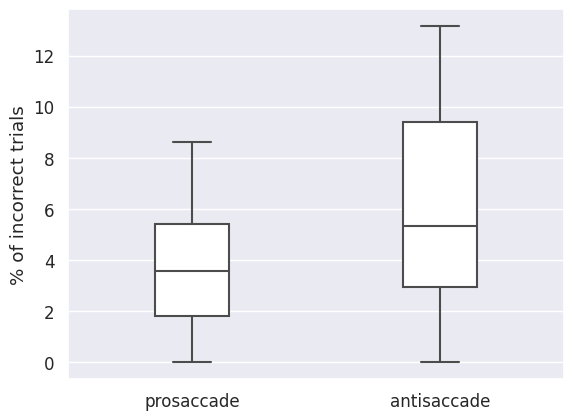

In [49]:
# Plot errors
ax = sns.boxplot(
    data=df_blocks_filtered[["prosaccade_errors_perc", "antisaccade_errors_perc"]],
    width=0.3,
)
ax.set_ylabel("% of incorrect trials")
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['prosaccade', 'antisaccade']
ax.set_xticklabels(labels)

boxes = ax.patches

for i, box in enumerate(boxes):
    box.set_facecolor("w")


p_value = round((
    ranksums(
        df_blocks_filtered["prosaccade_errors_perc"],
        df_blocks_filtered["antisaccade_errors_perc"],
    )[1]
), 4)

print(p_value)
print(f"N={len(df_blocks_filtered)}, blocks={df_blocks_filtered['remained_blocks'].max()}")

print(f"Cantidad de bloques filtrados: {(len(df_blocks_filtered['remained_blocks']) * 16)  - df_blocks_filtered['remained_blocks'].sum()}")

# plt.title(f"""
# Percentage of incorrect trials
# N suj = {len(df_blocks_filtered)}
# blocks = {df_blocks_filtered['remained_blocks'].max()}
# p_value = {p_value}
# """)
df_blocks_filtered.describe()[["prosaccade_errors_perc", "antisaccade_errors_perc"]]

In [57]:
print("means:") 
print(df_blocks_filtered.describe()[["prosaccade_errors_perc", "antisaccade_errors_perc"]].loc['mean',:].round(1), end='\n\n')
print("std:") 
print(df_blocks_filtered.describe()[["prosaccade_errors_perc", "antisaccade_errors_perc"]].loc['std',:].round(1), end='\n\n')
print("median:") 
print(df_blocks_filtered.describe()[["prosaccade_errors_perc", "antisaccade_errors_perc"]].loc['50%',:].round(1), end='\n\n')
print("25%:",) 
print(df_blocks_filtered.describe()[["prosaccade_errors_perc", "antisaccade_errors_perc"]].loc['25%',:].round(1), end='\n\n')
print("75%:") 
print(df_blocks_filtered.describe()[["prosaccade_errors_perc", "antisaccade_errors_perc"]].loc['75%',:].round(1), end='\n\n')

means:
prosaccade_errors_perc     3.9
antisaccade_errors_perc    6.0
Name: mean, dtype: float64

std:
prosaccade_errors_perc     2.6
antisaccade_errors_perc    3.9
Name: std, dtype: float64

median:
prosaccade_errors_perc     3.6
antisaccade_errors_perc    5.3
Name: 50%, dtype: float64

25%:
prosaccade_errors_perc     1.8
antisaccade_errors_perc    2.9
Name: 25%, dtype: float64

75%:
prosaccade_errors_perc     5.4
antisaccade_errors_perc    9.4
Name: 75%, dtype: float64



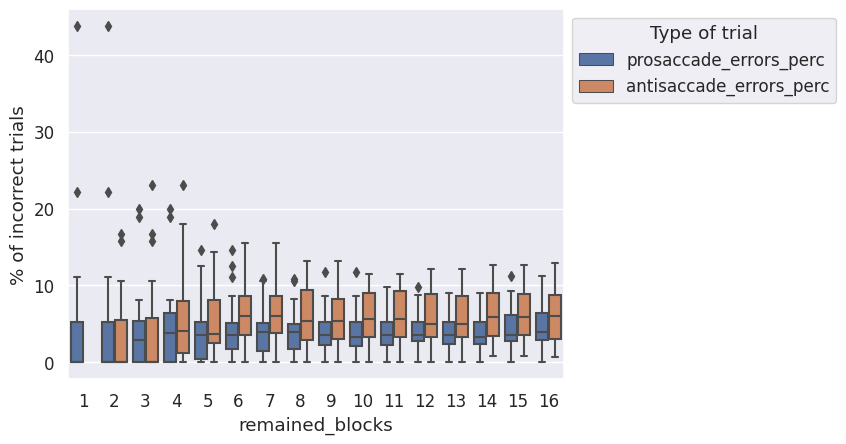

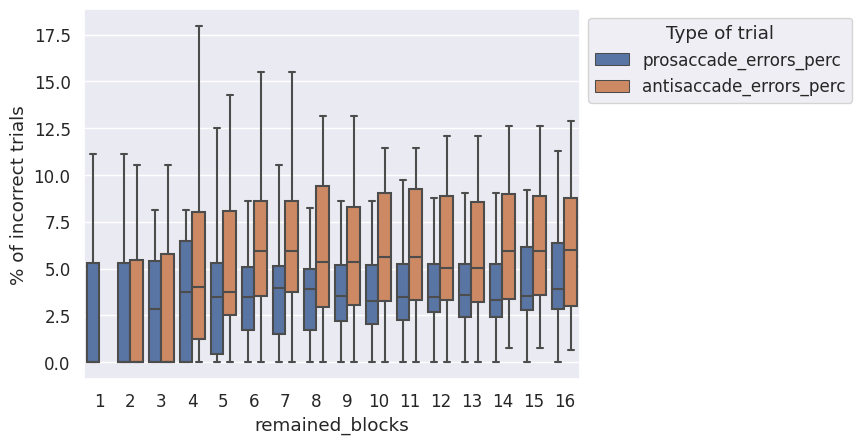

In [49]:
# Incorrectos por bloque
all_dfs = []
for last_block in range(1, 17):
    # filtrar bloques

    FIRST_BLOCK = 1
    LAST_BLOCK = last_block

    _df_blocks_filtered = (
        df_all_blocks.query(
            "prosaccade_errors < @MAX_NUMBER_INCORRECTS_BY_BLOCK and antisaccade_errors < @MAX_NUMBER_INCORRECTS_BY_BLOCK and @FIRST_BLOCK <= block <= @LAST_BLOCK"
        )  # Con la mitad de los bloques
        .groupby("subject")
        .agg(
            {
                "prosaccade_errors": "sum",
                "antisaccade_errors": "sum",
                "prosaccade_trials_remained": "sum",
                "antisaccade_trials_remained": "sum",
                "pro_sacc_errors_rt": "sum",
                "pro_sacc_correct_rt": "sum",
                "anti_sacc_errors_rt": "sum",
                "anti_sacc_correct_rt": "sum",
                "pro_sacc_errors_rt_median": np.nanmean,
                "anti_sacc_errors_rt_median": np.nanmean,
                "pro_sacc_correct_rt_median": np.nanmean,
                "anti_sacc_correct_rt_median": np.nanmean,
                "block": lambda x: x.nunique(),
            }
        )
    )

    _df_blocks_filtered = _df_blocks_filtered.rename({"block": "remained_blocks"}, axis=1)


    # Percentage
    _df_blocks_filtered["prosaccade_errors_perc"] = (
        _df_blocks_filtered["prosaccade_errors"]
        / _df_blocks_filtered["prosaccade_trials_remained"]
    ) * 100


    _df_blocks_filtered["antisaccade_errors_perc"] = (
        _df_blocks_filtered["antisaccade_errors"]
        / _df_blocks_filtered["antisaccade_trials_remained"]
    ) * 100
    all_dfs.append(_df_blocks_filtered)

all_dataframes = pd.concat(all_dfs)

all_dataframes

# Plot
ax = sns.boxplot(
    data=all_dataframes.melt(id_vars=['remained_blocks'], value_vars=['prosaccade_errors_perc', 'antisaccade_errors_perc'],
                 var_name='Type of trial', value_name='% of incorrect trials'),
    x='remained_blocks',
    y='% of incorrect trials',
    hue='Type of trial',
    showfliers = True
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

ax = sns.boxplot(
    data=all_dataframes.melt(id_vars=['remained_blocks'], value_vars=['prosaccade_errors_perc', 'antisaccade_errors_perc'],
                 var_name='Type of trial', value_name='% of incorrect trials'),
    x='remained_blocks',
    y='% of incorrect trials',
    hue='Type of trial',
    showfliers = False
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


plt.show()

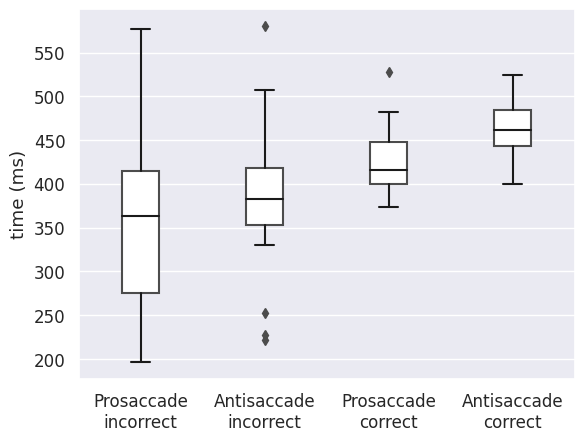

,delta_errors,prosaccade_errors,antisaccade_errors,prosaccade_trials_remained,antisaccade_trials_remained,pro_sacc_errors_rt_median,anti_sacc_errors_rt_median,pro_sacc_correct_rt_median,anti_sacc_correct_rt_median,remained_blocks,age,px2degree,max_number_incorrect_by_block,prosaccade_errors_perc,antisaccade_errors_perc
count,26.000000,26.000000,26.000000,26.000000,26.000000,22.000000,24.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.0,26.000000,26.000000
mean,2.153846,2.153846,4.307692,54.423077,72.076923,362.386326,383.460538,424.574231,463.295785,6.884615,31.769231,34.468462,10.0,3.858359,5.987505
std,2.962328,1.541228,2.825162,5.615501,8.676050,110.981610,80.966569,35.570188,30.150567,0.325813,6.094638,3.713438,0.0,2.636911,3.914832
min,-4.000000,0.000000,0.000000,39.000000,45.000000,196.265000,222.180000,374.085000,399.388750,6.000000,22.000000,27.430000,10.0,0.000000,0.000000
25%,0.000000,1.000000,2.000000,52.750000,69.500000,275.068750,352.956563,400.060000,443.581875,7.000000,28.250000,31.250000,10.0,1.815789,2.931489
50%,2.000000,2.000000,4.000000,57.000000,75.500000,363.222500,382.520833,415.817500,461.001875,7.000000,30.500000,35.850000,10.0,3.572568,5.337129
75%,4.000000,3.000000,6.000000,58.000000,78.000000,414.385000,418.386250,448.299583,483.926250,7.000000,33.000000,37.407500,10.0,5.406699,9.410495
max,8.000000,5.000000,10.000000,59.000000,80.000000,577.005000,580.055000,527.448333,523.926667,7.000000,51.000000,39.840000,10.0,8.620690,13.157895


In [58]:
# RT VERSION CON BLOQUES

# Boxplot with means
ax = sns.boxplot(
    data=df_blocks_filtered[
        [
            "pro_sacc_errors_rt_median",
            "anti_sacc_errors_rt_median",
            "pro_sacc_correct_rt_median",
            "anti_sacc_correct_rt_median",
        ]
    ],
    width=0.3,
)

boxes = ax.patches

for i, box in enumerate(boxes):
    box.set_facecolor("w")

plt.ylabel("time (ms)")
ax.set_xticklabels(
    [
        "Prosaccade\nincorrect",
        "Antisaccade\nincorrect",
        "Prosaccade\ncorrect",
        "Antisaccade\ncorrect",
    ]
)

plt.setp(ax.artists, edgecolor="k", facecolor="w")
plt.setp(ax.lines, color="k")


# title = (
#     f"""RT condition [pro - anti] x result [correct - incorrect]
# N suj = {len(df_blocks_filtered)}
# blocks = {df_blocks_filtered['remained_blocks'].max()}￼
# ranksums pro_sacc_errors_rt_median vs. anti_sacc_errors_rt_median:  {Decimal(ranksums(df_blocks_filtered['pro_sacc_errors_rt_median'],df_blocks_filtered['anti_sacc_errors_rt_median'], nan_policy='omit')[1]):.5f}
# ranksums pro_sacc_correct_rt_median vs. anti_sacc_correct_rt_median: {Decimal(ranksums(df_blocks_filtered['pro_sacc_correct_rt_median'],df_blocks_filtered['anti_sacc_correct_rt_median'], nan_policy='omit')[1]):.5f}
# """
# )

# print(title)


# plt.title(title)
plt.show()
df_blocks_filtered.describe()

In [65]:
df_blocks_filtered[
        [
            "pro_sacc_errors_rt_median",
            "anti_sacc_errors_rt_median",
            "pro_sacc_correct_rt_median",
            "anti_sacc_correct_rt_median",
        ]
    ].describe()

,pro_sacc_errors_rt_median,anti_sacc_errors_rt_median,pro_sacc_correct_rt_median,anti_sacc_correct_rt_median
count,22.000000,24.000000,26.000000,26.000000
mean,362.386326,383.460538,424.574231,463.295785
std,110.981610,80.966569,35.570188,30.150567
min,196.265000,222.180000,374.085000,399.388750
25%,275.068750,352.956563,400.060000,443.581875
50%,363.222500,382.520833,415.817500,461.001875
75%,414.385000,418.386250,448.299583,483.926250
max,577.005000,580.055000,527.448333,523.926667


In [63]:
df_blocks_filtered.describe()[
            "pro_sacc_errors_rt_median",
            "anti_sacc_errors_rt_median",
            "pro_sacc_correct_rt_median",
            "anti_sacc_correct_rt_median",
        ]

KeyError: ('pro_sacc_errors_rt_median', 'anti_sacc_errors_rt_median', 'pro_sacc_correct_rt_median', 'anti_sacc_correct_rt_median')

### PLOT EYE DATA

---
99
suj_number: 99
prosaccade


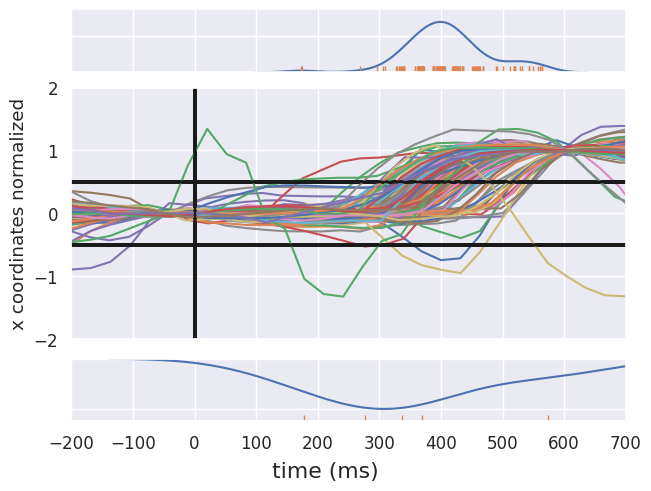

suj_number: 99
antisaccade


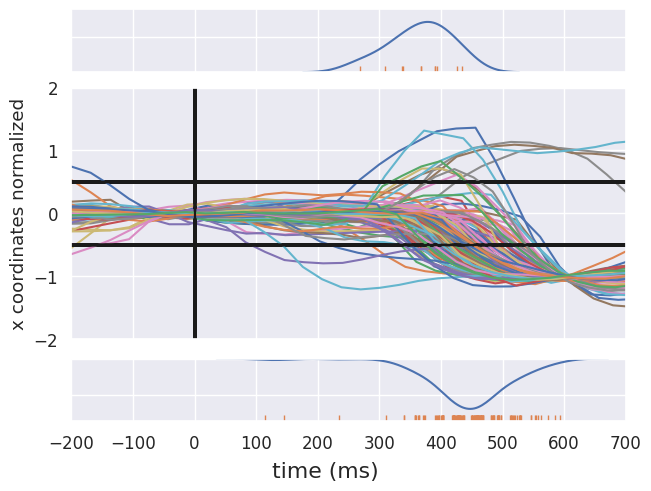

---
110
suj_number: 110
prosaccade


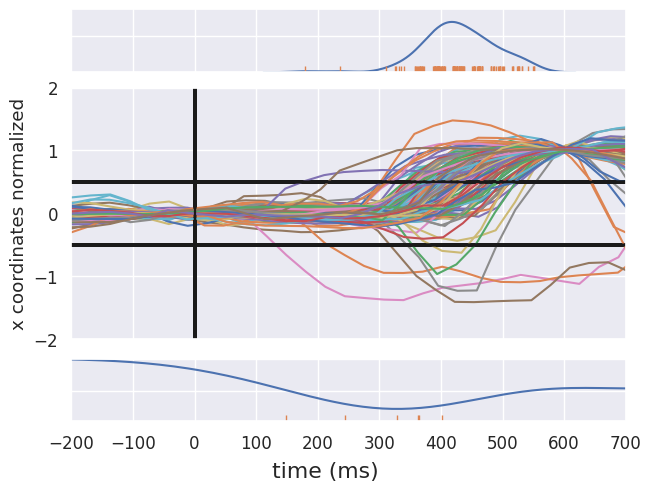

suj_number: 110
antisaccade


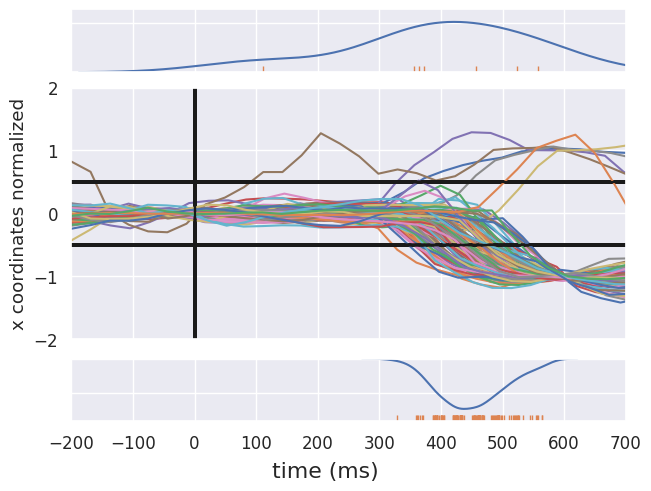

---
124
suj_number: 124
prosaccade


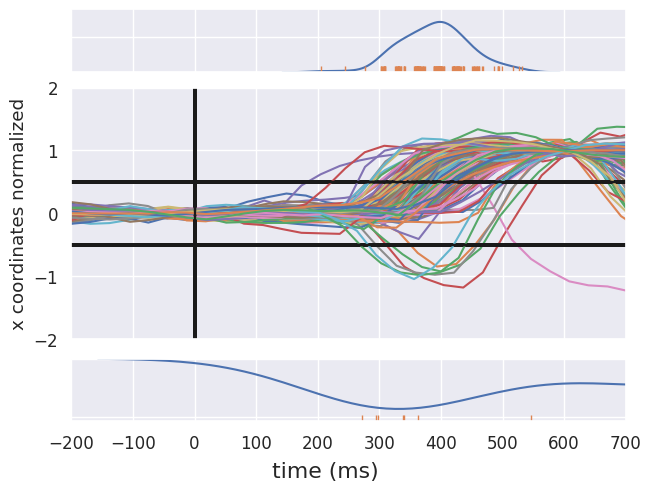

suj_number: 124


/tmp/ipykernel_204276/3241454161.py:204: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data_error, ax=axs[0])


antisaccade


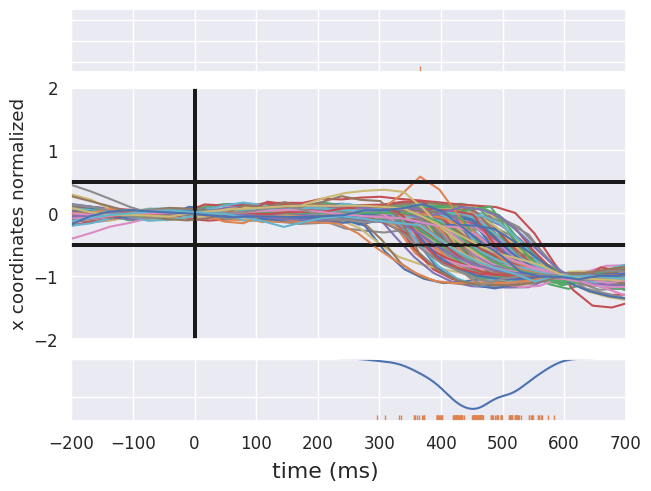

---
115
suj_number: 115
prosaccade


KeyboardInterrupt: 

In [26]:
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))

# Plot all subjects
for file in enumerate(ALL_FILES_RAW):
    print("---")
    suj = str(file).split("/")[-1].split(".")[0].split("_")[-1]
    print(suj)
    one_subject(df_processed_signal, suj, "prosaccade")
    one_subject(df_processed_signal, suj, "antisaccade")

### Saccade detection


### Preparing test dataset

`infile`: Data file with eye gaze recordings to process. <br>
The first two columns in this file must contain x and y coordinates, while each line is a timepoint (no header). <br>
The file is read with NumPy's recfromcsv and may be compressed. The columns are expected to be seperated by tabulators (\t).

In [ ]:
for data in df_blocks_filtered.iloc[0]['prosaccade']:
    print(data)
    break

### Analisis trial por trial

In [ ]:

# Lo hace trial por trial pero me parece que no es lo mejor
# Chequear que la cantidad de trials finales tengan sentido
# OUT_FOLDER = "./pro_saccade_detection_by_trial/"
OUT_FOLDER = "./saccade_detection/"
SFREQ = 30  # Sampling rate after inteporlation
TYPE_OF_SACCADE = "prosaccade"

for SUJ in range(len(df_blocks_filtered)):
    for trial_num, data in enumerate(df_blocks_filtered.iloc[SUJ][TYPE_OF_SACCADE]):
        print(f"Suj: {df_blocks_filtered.index[SUJ]}, trial: {trial_num}")
        rows = []
        # Remodnav parameters
        FNAME = f"{df_blocks_filtered.index[SUJ]}_detect_sacc_trial_{trial_num}.csv"
        PX2DEG = df_blocks_filtered["px2degree"][SUJ]
        OUT_FNAME = f"fix_sac_detection_suj_{df_blocks_filtered.index[SUJ]}_trial_{trial_num}.tsv"
        t_samples = data[0]
        x_samples = data[1]
        y_samples = data[2]

        # create a new row as a dictionary
        new_row = {
            "x": x_samples,
            "y": y_samples,
            "t": t_samples,
            "trial": trial_num,
        }
        rows.append(new_row)

        df_sacc = pd.DataFrame(rows)
        df_sacc = df_sacc.explode(["x", "y", "t"], ignore_index=True)
        df_sacc = df_sacc[["x", "y"]]

        # One trial data
        samples = len(x_samples)
        df_sacc.iloc[:samples + 2].to_csv(
            OUT_FOLDER + FNAME, sep="\t", header=False, index=False
        )

        print("\nRunning saccades and fixations detection")

        # Run Remodnav not considering pursuit class and min fixations 100 ms
        command = (
            f"remodnav {OUT_FOLDER + FNAME} {OUT_FOLDER  + OUT_FNAME} {PX2DEG} {SFREQ} --savgol-length {0.1} --min-pursuit-duration {2} "
            f"--max-pso-duration {0.0} --min-fixation-duration {0.05} --max-vel {5000}"
        )
        os.system(command)
    break
    # # Read results file with detections
    # df_sac_fix = pd.read_csv(OUT_FNAME, sep="\t")

print("End of saccades and fixations detection")


In [ ]:
import glob
path = './saccade_detection_by_trial/'
df = pd.concat([pd.read_csv(f, sep='\t' ) for f in glob.glob(path+'fix_sac_detection_suj_115_trial_*.tsv')])
df.shape


### VERSION POR SUJETO SIN SEPARACION POR TRIALS

In [ ]:
#Lo hace trial por trial pero me parece que no es lo mejor
# Chequear que la cantidad de trials finales tengan sentido
OUT_FOLDER = './saccade_detection/'
SFREQ = 30 # Sampling rate after inteporlation

for SUJ in range(len(df_blocks_filtered)):
    FNAME = f"{df_blocks_filtered.index[SUJ]}_detect_sacc_trial.csv"
    PX2DEG = df_blocks_filtered['px2degree'][SUJ]
    OUT_FNAME = f"fix_sac_detection_suj_{df_blocks_filtered.index[SUJ]}_trial.tsv"
    rows = []
    for trial, data in enumerate(df_blocks_filtered.iloc[SUJ]["prosaccade"]):
        print(f"Suj: {df_blocks_filtered.index[SUJ]}, trial: {trial}")
        # Remodnav parameters
        x_samples = data[1]
        t_samples = data[0]
        
        # create a new row as a dictionary
        new_row = {"x": x_samples, "y": np.zeros(len(x_samples)), "t": t_samples}
        rows.append(new_row)

    df_sacc_detect_test = pd.DataFrame(rows)
    df_sacc_detect_test_expl = df_sacc_detect_test.explode(
        ["x", "y", "t"], ignore_index=True
    )

    df_sacc_detect_test_expl = df_sacc_detect_test_expl[['x', 'y']]

    # Datos de un sujeto
    samples = len(x_samples)
    df_sacc_detect_test_expl.to_csv(OUT_FOLDER + FNAME, sep="\t", header=False, index=False)

    print("\nRunning saccades and fixations detection")

    
    # Run Remodnav not considering pursuit class and min fixations 100 ms
    command = (
        f"remodnav {OUT_FOLDER + FNAME} {OUT_FOLDER  + OUT_FNAME} {PX2DEG} {SFREQ} --savgol-length {0.1} --min-pursuit-duration {2} "
        f"--max-pso-duration {0.0} --min-fixation-duration {0.05} --max-vel {5000}"
    )
    os.system(command)


    # # Read results file with detections
    # df_sac_fix = pd.read_csv(OUT_FNAME, sep="\t")

print("End of saccades and fixations detection")
    
    

### Porcentaje de sacadas detectadas con el algoritmo

In [ ]:
sujetos = [int(i.split('/')[-1].split('.')[0].split('_')[-1]) for i in glob.glob('raw_data/*.csv')]

perc_sacc_detected = {}

for sujeto in sujetos:
    all_dfs_one_suj = []
    path = './pro_saccade_detection_by_trial/'

    for f in sorted(glob.glob(path+f'fix_sac_detection_suj_{sujeto}_trial_*.tsv'), key=os.path.getmtime):
        _df = pd.read_csv(f, sep='\t' )
        _df['trial'] = f.split("/")[-1].split('.')[0].split("_")[-1]
        all_dfs_one_suj.append(_df)


    dfs = pd.concat(all_dfs_one_suj).reset_index()
    res = (dfs.query("label == 'SACC' or label == 'ISAC'")['trial'].nunique() / dfs['trial'].nunique())  * 100
    dfs.query("label == 'SACC' or label == 'ISAC'").reset_index()
    perc_sacc_detected[sujeto] = res

perc_sacc_detected
sns.histplot(perc_sacc_detected.values())

In [ ]:
sorted(perc_sacc_detected.items(), key=lambda x:x[0])

## **Other**

### Testeo de normalidad

In [ ]:
# Testeando normalidad
pro_data = df_blocks_filtered["prosaccade_errors_perc"],
anti_data = df_blocks_filtered["antisaccade_errors_perc"],
sm.qqplot(pro_data[0], line='45', fit = True)
sm.qqplot(anti_data[0], line='45', fit = True)
plt.show()

In [ ]:
# Podemos poner 0 - 150
# Graficar solo los eerrores

# Calcular para cada trial correcto o incorrecto y el tiempo (y promedios +- desvio)
# Tablita cmo en la tesis (2 porcentajes y 4 tiempos)


In [ ]:
# Tiempos en el experimento (ms)

# Inter-trial time (ITI) = 925
# Prensentacion de la cue de tipo de tarea =  getRandomIntInclusive(900, 1500) -> es variable!
# Presentacion del cuadrado central que es igual para todos (cue sin informacion) = 200
# tiempo durante el que aparece la visualCue = 150
# Tiempo para responder (responseAwait) = 650

925 + 1500 + 200 + 150 + 650
